In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from transformers import BertForSequenceClassification, BertTokenizer
import torch.nn as nn
from torch.optim import AdamW
import functions_text_model as functions

c:\Users\celin\anaconda3\envs\DLproj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we have to load the datasets, which have already been prepared in `data_labelling_json.ipynb`. The different datasets are:
- mixed_data_enriched: all utterances for which the speaker gender has been identified, augmented in order to be balanced.
- F_data: all utterances in which the speaker is a woman.
- M_data_enriched: all utterances in which the speaker is a man, augmented in order to be balanced.

In [2]:
# Load the data from the JSON files
with open('data/mixed_data.json') as file:
    mixed_data = json.load(file)

with open('data/F_data.json') as file:
    F_data = json.load(file)

with open('data/M_data.json') as file:
    M_data = json.load(file)

with open('data/mixed_data_enriched.json') as file:
    mixed_data_enriched = json.load(file)

with open('data/M_data_enriched.json') as file:
    M_data_enriched = json.load(file)

# Convert the data to lists of dictionaries
mixed_data = list(mixed_data.values())
F_data = list(F_data.values())
M_data = list(M_data.values())
mixed_data_enriched = list(mixed_data_enriched.values())
M_data_enriched = list(M_data_enriched.values())

Let's define some classes and functions needed in the training pipeline.

In [3]:
# Class for the PyTorch sarcasm detection Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        context = item['context']
        utterance_and_context = ' '.join([sentence for sentence in context] + [utterance]) # Combining the utterance and its context into one string.
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance_and_context)
        return input_ids.flatten(), attention_mask.flatten(), sarcasm


# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

We will now train 3 different models: 
- one model will be trained on the mixed augmented data (mixed_data_enriched)
- one model will be trained on utterances from female speakers only (F_data)
- one model will be trained on utterances from male speakers only (M_data_enriched)

train Loss: 0.5602,  ACC: 0.7571, F1-weighted: 0.7486


100%|██████████| 6/6 [00:00<00:00, 13.84it/s]


eval Loss: 0.5802,  ACC: 0.7257, F1-weighted: 0.7183


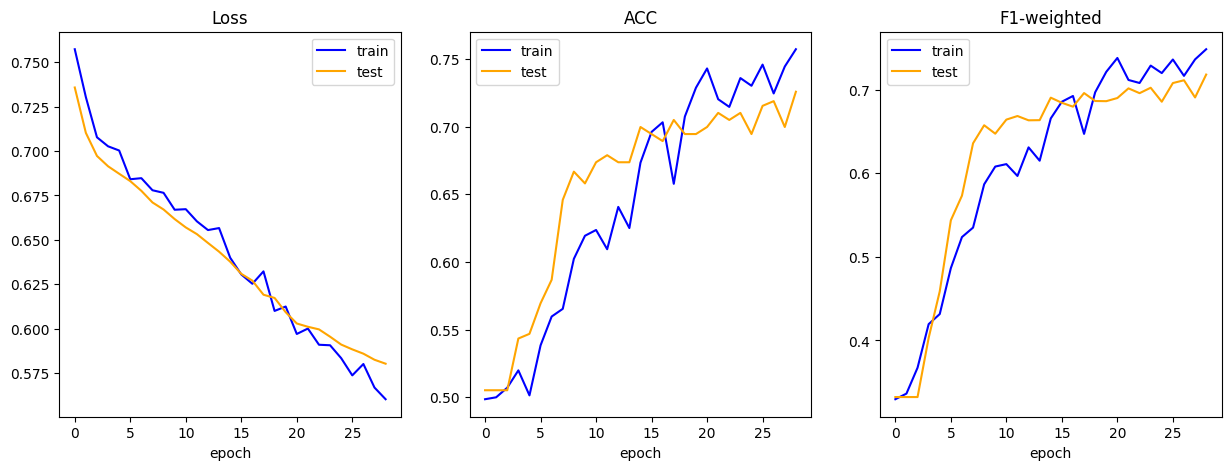

train loss [0.757292544299906, 0.7303156527605924, 0.7077114202759482, 0.7026390812613748, 0.7002681168642911, 0.6840881244702772, 0.6846949431029233, 0.6778979301452637, 0.6764447553591295, 0.6669132926247336, 0.6672400073571638, 0.6604034981944344, 0.655475990338759, 0.6566041166132147, 0.6399093107743696, 0.6304985880851746, 0.6252398003231395, 0.6322309049693021, 0.6099521246823397, 0.6124327426606958, 0.5969801816073331, 0.6000331558964469, 0.590912485664541, 0.5906210162422874, 0.5833585533228788, 0.573671659285372, 0.5800694281404669, 0.5668075734918768, 0.5602458579973741] test loss [0.7357492844263712, 0.7101888358592987, 0.6972070137659708, 0.6913895408312479, 0.6871864298979441, 0.6830300788084666, 0.6775631507237753, 0.6710284451643626, 0.6670582493146261, 0.6616601149241129, 0.6569673120975494, 0.6532020270824432, 0.648219883441925, 0.6433035433292389, 0.6376746992270151, 0.6308269302050272, 0.6270060141881307, 0.6190784970919291, 0.6172717114289602, 0.6092468698819479, 0.

In [71]:
# MIXED MODEL ENRICHED

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.00001
num_epochs = 29
batch_size = 32
weight_decay = 0.1
dropout_prob = 0.2

# Split dataset into training and testing
dataset = SarcasmDataset(mixed_data_enriched)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
mixed_model_enriched = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

mixed_model_enriched.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

mixed_model_enriched.to(device)

# Define optimizer and criterion
optimizer = AdamW(mixed_model_enriched.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(mixed_model_enriched, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(mixed_model_enriched, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
torch.save(mixed_model_enriched.state_dict(), 'models/mixed_model_text.pth')

train Loss: 0.5948,  ACC: 0.8214, F1-weighted: 0.7878


100%|██████████| 6/6 [00:00<00:00, 40.69it/s]


eval Loss: 0.5775,  ACC: 0.7917, F1-weighted: 0.7770


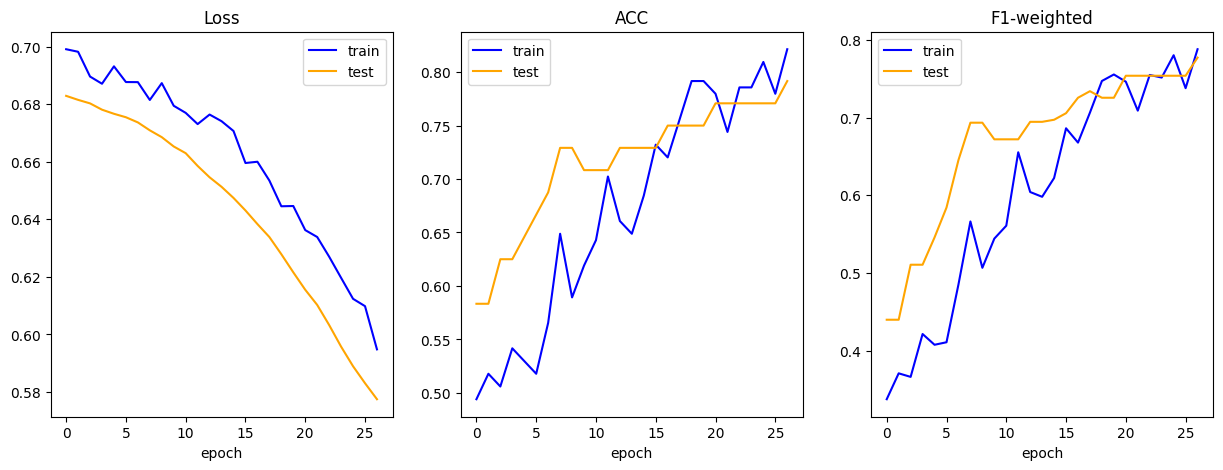

train loss [0.6991306117602757, 0.6982449548585075, 0.6896271450178963, 0.6871308911414373, 0.6931794796671186, 0.6877201823961168, 0.6876888331912813, 0.6814963675680614, 0.6873428935096377, 0.6794703659557161, 0.6770055549485343, 0.6731047062646776, 0.6764221588770548, 0.674110472202301, 0.6707017336572919, 0.6595762088185265, 0.6600171270824614, 0.6534789885793414, 0.6445373694101969, 0.6446274405434018, 0.636257373151325, 0.6338545509747097, 0.6270156701405843, 0.6196558617410206, 0.6123665826661246, 0.6098193015371051, 0.5947946792557126] test loss [0.6829203764597574, 0.6815265615781149, 0.6803017656008402, 0.6781110862890879, 0.6766873300075531, 0.6754837433497111, 0.6736886103947958, 0.6709312200546265, 0.6685597399870554, 0.6653220355510712, 0.6629899938901266, 0.6585615972677866, 0.6546051402886709, 0.6512996157010397, 0.6474387049674988, 0.6430832048257192, 0.6383512417475382, 0.6338467995325724, 0.627876470486323, 0.6215833822886149, 0.6155195534229279, 0.6102490325768789, 

In [67]:
# FEMALE MODEL

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.00001
num_epochs = 27
batch_size = 8
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
dataset = SarcasmDataset(F_data)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
F_model = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

F_model.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

F_model.to(device)

# Define optimizer and criterion
optimizer = AdamW(F_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(F_model, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(F_model, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
torch.save(F_model.state_dict(), 'models/F_model_text.pth')

train Loss: 0.6532,  ACC: 0.6515, F1-weighted: 0.6487


100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


eval Loss: 0.6515,  ACC: 0.6851, F1-weighted: 0.6759


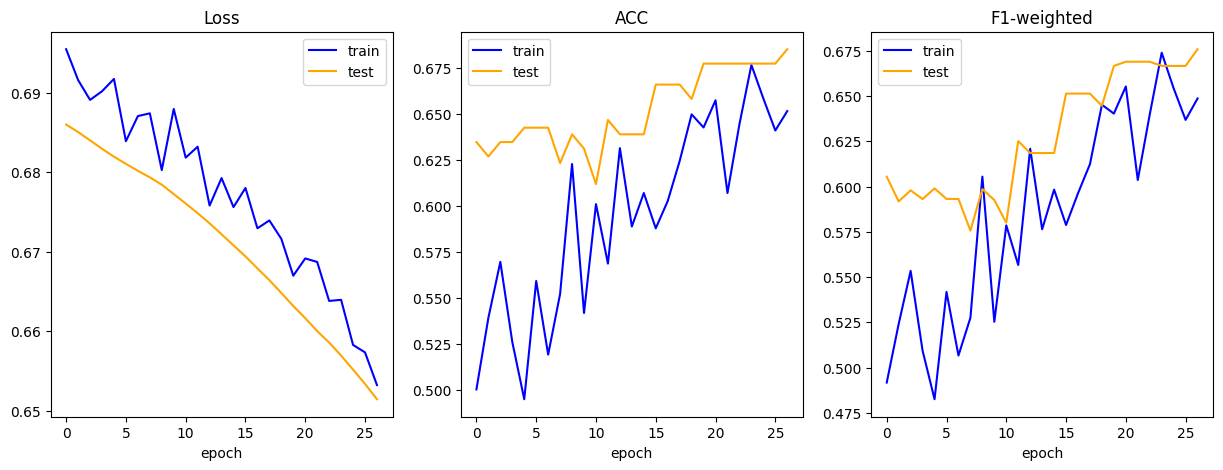

train loss [0.6954556206862131, 0.6915847957134247, 0.6890839437643687, 0.6901673773924509, 0.6917238831520081, 0.6838917235533396, 0.6870496869087219, 0.6873954236507416, 0.6802595059076945, 0.6879436473051707, 0.681827316681544, 0.683199425538381, 0.6757985055446625, 0.6792585353056589, 0.675607701142629, 0.6780131359895071, 0.6729395389556885, 0.6739292641480764, 0.6716136535008749, 0.666985273361206, 0.669153481721878, 0.6687096556027731, 0.6638093292713165, 0.6639480491479238, 0.6582774817943573, 0.6573411325613657, 0.6532339652379354] test loss [0.685982882976532, 0.685041755437851, 0.6839940547943115, 0.6829391419887543, 0.6819466650485992, 0.6810463070869446, 0.6801705360412598, 0.6793453097343445, 0.6784276068210602, 0.6772444248199463, 0.6760576367378235, 0.6748460531234741, 0.6735648214817047, 0.6721865832805634, 0.6707969009876251, 0.6694086194038391, 0.6679052412509918, 0.6664190590381622, 0.6648102402687073, 0.6631733179092407, 0.6616405248641968, 0.6600130498409271, 0.65

In [69]:
# MALE MODEL ENRICHED

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.00001
num_epochs = 27
batch_size = 64
weight_decay = 0.05
dropout_prob = 0.1

# Split dataset into training and testing
dataset = SarcasmDataset(M_data_enriched)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
M_model_enriched = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

M_model_enriched.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

M_model_enriched.to(device)

# Define optimizer and criterion
optimizer = AdamW(M_model_enriched.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(M_model_enriched, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(M_model_enriched, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
torch.save(M_model_enriched.state_dict(), 'models/M_model_text.pth')